In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt

/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from tensorflow.keras.datasets import reuters

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Total train data and test data

In [4]:
len(train_data)

8982

In [5]:
len(test_data)

2246

Decode newswire back to text from numbers

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decode_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
decode_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

#### Preparing data

one hot encoding 

In [9]:
def vectorize_seq(seqs, dimention=10000):
    res = np.zeros((len(seqs), dimention))
    
    for i, seq in enumerate(seqs):
        res[i, seq] = 1.
        
    return res
    

In [10]:
x_train = vectorize_seq(train_data)
x_test = vectorize_seq(test_data)

naive approach without using keras lib - convert all labels to one hot encoding

In [11]:
def one_hot_encoding(labels, dimention=46):
    res = np.zeros((len(labels), dimention))
    
    for i, label in enumerate(labels):
        res[i, label] = 1.
        
    return res

In [12]:
y_train = one_hot_encoding(train_labels)
y_test = one_hot_encoding(test_labels)

### Building a model

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [14]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

In [21]:
model.compile(optimizer="rmsprop",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

let's set apart 1000 samples from train data to do validation

In [22]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

Let's train the model

In [23]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 30ms/step - loss: 3.1207 - accuracy: 0.3230 - val_loss: 1.7836 - val_accuracy: 0.6440
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 1.5634 - accuracy: 0.6975 - val_loss: 1.3652 - val_accuracy: 0.7120
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.1435 - accuracy: 0.7594 - val_loss: 1.1570 - val_accuracy: 0.7470
Epoch 4/20
16/16 [==============================] - 0s 18ms/step - loss: 0.8562 - accuracy: 0.8166 - val_loss: 1.0348 - val_accuracy: 0.7750
Epoch 5/20
16/16 [==============================] - 0s 18ms/step - loss: 0.6878 - accuracy: 0.8583 - val_loss: 0.9665 - val_accuracy: 0.7930
Epoch 6/20
16/16 [==============================] - 0s 18ms/step - loss: 0.5559 - accuracy: 0.8862 - val_loss: 0.8989 - val_accuracy: 0.8170
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.4168 - accuracy: 0.9149 - val_loss: 0.9005 - val_accuracy: 0.8140
Epoch 8/20
16

 Plotting the training and validation loss

In [24]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

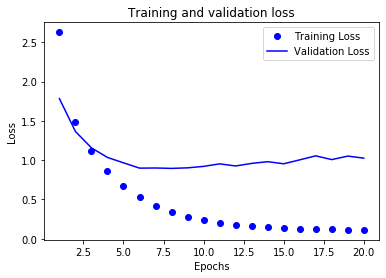

In [25]:
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Plotting the training and validation accuracy

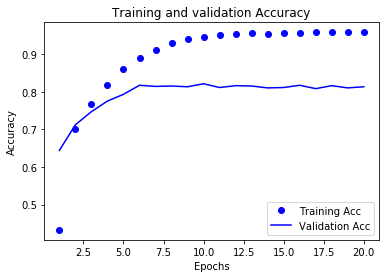

In [26]:
plt.clf()

plt.plot(epochs, acc, "bo", label="Training Acc")
plt.plot(epochs, val_acc, "b", label="Validation Acc")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The network begins to overfit after nine epochs. Let’s train a new network from scratch for six epochs and then evaluate it on the test set.

In [27]:
tf.keras.backend.clear_session()

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(optimizer="rmsprop",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(partial_x_train, partial_y_train, epochs=6, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)

Epoch 1/6
16/16 [==============================] - 1s 30ms/step - loss: 2.9768 - accuracy: 0.4301 - val_loss: 1.6410 - val_accuracy: 0.6620
Epoch 2/6
16/16 [==============================] - 0s 19ms/step - loss: 1.4319 - accuracy: 0.6987 - val_loss: 1.2814 - val_accuracy: 0.7170
Epoch 3/6
16/16 [==============================] - 0s 18ms/step - loss: 1.0533 - accuracy: 0.7704 - val_loss: 1.1455 - val_accuracy: 0.7430
Epoch 4/6
16/16 [==============================] - 0s 21ms/step - loss: 0.8449 - accuracy: 0.8125 - val_loss: 1.0433 - val_accuracy: 0.7860
Epoch 5/6
16/16 [==============================] - 0s 20ms/step - loss: 0.6639 - accuracy: 0.8566 - val_loss: 0.9840 - val_accuracy: 0.7920
Epoch 6/6
71/71 [==============================] - 0s 2ms/step - loss: 0.9976 - accuracy: 0.7765


In [29]:
results

[0.9975882768630981, 0.7764915227890015]

77% accuracy. Pretty good without any tuning. 

#### Another way to encode labels 

In [30]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [31]:
y_train

array([ 3,  4,  3, ..., 25,  3, 25])

In [32]:
y_test

array([ 3, 10,  1, ...,  3,  3, 24])

With this encoding change we have to use 'sparse_categorical_crossentropy' as our loss function

In [33]:
tf.keras.backend.clear_session()

In [34]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(partial_x_train, partial_y_train, epochs=6, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, y_test)

Epoch 1/6
16/16 [==============================] - 1s 26ms/step - loss: 3.3050 - accuracy: 0.3268 - val_loss: 1.8882 - val_accuracy: 0.6340
Epoch 2/6
16/16 [==============================] - 0s 20ms/step - loss: 1.6423 - accuracy: 0.6747 - val_loss: 1.3404 - val_accuracy: 0.7170
Epoch 3/6
16/16 [==============================] - 0s 19ms/step - loss: 1.1219 - accuracy: 0.7608 - val_loss: 1.1529 - val_accuracy: 0.7570
Epoch 4/6
16/16 [==============================] - 0s 19ms/step - loss: 0.8823 - accuracy: 0.8155 - val_loss: 1.0644 - val_accuracy: 0.7750
Epoch 5/6
16/16 [==============================] - 0s 20ms/step - loss: 0.6959 - accuracy: 0.8539 - val_loss: 0.9678 - val_accuracy: 0.7960
Epoch 6/6
71/71 [==============================] - 0s 1ms/step - loss: 0.9957 - accuracy: 0.7796


Note: Pretty much the same result 77% as with one hot encoding labels.